## Data Processing

### 1. Create a list for all images file path

In [1]:
import os

all_file_paths = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        all_file_paths.append(os.path.join(dirname, filename))

In [2]:
len(all_file_paths)

4317

In [3]:
all_file_paths[0]

'/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg'

### 2. Create dictionary where each flower has its own list 

In [4]:
import os
from collections import defaultdict

# Create dictionary where each flower has its own list
flower_dict = defaultdict(list)

for path in all_file_paths:
    # Get the directory name from the full path
    directory = os.path.dirname(path)
    
    # Extract folder name (flower class)
    flower_class = os.path.basename(directory)
    
    # Add path to the corresponding flower list
    flower_dict[flower_class].append(path)

# Convert defaultdict to normal dict
flower_dict = dict(flower_dict)

# Print summary
for flower, paths in flower_dict.items():
    print(f"{flower}: {len(paths)} images")


dandelion: 1052 images
daisy: 764 images
sunflower: 733 images
tulip: 984 images
rose: 784 images


### 3. Create a flower label dictionary

In [5]:
# Assigning labels to each flower category
flower_label_dict = {'dandelion': 0,
                      'daisy': 1,
                      'sunflower': 2,
                      'tulip': 3,
                      'rose': 4 }
flower_label_dict

{'dandelion': 0, 'daisy': 1, 'sunflower': 2, 'tulip': 3, 'rose': 4}

### 4. Check size distribution of images

In [6]:
# Check the size of some random images
from PIL import Image
import random

# Pick 5 random image path
sample_path = random.sample(all_file_paths,5)

# Check size of these images
for p in sample_path:
    img = Image.open(p)
    print(f'{p}: size {img.size}')

/kaggle/input/flowers-recognition/flowers/daisy/5435522104_1d6a61b431_n.jpg: size (320, 240)
/kaggle/input/flowers-recognition/flowers/rose/3873271620_1d9d314f01_n.jpg: size (320, 222)
/kaggle/input/flowers-recognition/flowers/tulip/5443985113_54e9f608b3_n.jpg: size (240, 164)
/kaggle/input/flowers-recognition/flowers/dandelion/34690477346_6af75b993b_n.jpg: size (240, 180)
/kaggle/input/flowers-recognition/flowers/dandelion/14728922673_99086a3818_n.jpg: size (320, 234)


* As the size of images are not same, will resize all the images to (224, 224)

### 5. Resize all the images

In [7]:
# Standard size 
image_size = (224, 224)

# Store the features and labels in X,y
X, y = [],[]

# Loop to resize the dataset and store into X,y
for flowers, paths in flower_dict.items():
    for p in paths:
        img = Image.open(p)
        resized_img = img.resize(image_size)
        X.append(resized_img)
        y.append(flower_label_dict[flowers])

### 6. Convert X and y to NumPy arrays(Keras doesn’t accept PIL images directly)

In [8]:
import numpy as np

X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(4317, 224, 224, 3)
(4317,)


## Train Test Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42)

## Normalize the Images
* As the images are raw pixel values (0–255). Will normalize them to (0–1)

In [10]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

## Build a CNN Model

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    # To define input shape
    layers.Input(shape=(224, 224, 3)),

    # 1st convolution layer to extract low-level features (edges, textures)
    layers.Conv2D(32, (3,3), padding='same', activation='relu'), 
    layers.MaxPooling2D((2,2)),

    # 2nd Convolution layer to extract more abstract features
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    # 3rd Convolution layer to extract deeper/high-level features
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Flatten the 3D feature maps into a 1D vector
    layers.Flatten(),

    # Fully-connected dense layer for learning nonlinear relationships
    layers.Dense(128, activation='relu'),

    # Output layer: 5 flower classes
    layers.Dense(5, activation='softmax')
])

## Compile the Model

In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy', # for multiclass classification
    metrics = ['accuracy'])

## Train the Model

In [13]:
history = model.fit(
    X_train_scaled, y_train,
    batch_size = 32,
    epochs=15,
    validation_data = (X_test_scaled, y_test))

Epoch 1/15


I0000 00:00:1764254547.182058     110 service.cc:148] XLA service 0x7ce61c004e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764254547.183459     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764254547.183487     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764254547.569093     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/95 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.2257 - loss: 4.6792 

I0000 00:00:1764254553.097939     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.3333 - loss: 2.0019 - val_accuracy: 0.5386 - val_loss: 1.1448
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5439 - loss: 1.1126 - val_accuracy: 0.6258 - val_loss: 0.9867
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.6443 - loss: 0.9108 - val_accuracy: 0.6296 - val_loss: 0.9616
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.7418 - loss: 0.6758 - val_accuracy: 0.6281 - val_loss: 1.0778
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8489 - loss: 0.4116 - val_accuracy: 0.6520 - val_loss: 1.1627
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9378 - loss: 0.1940 - val_accuracy: 0.6412 - val_loss: 1.4394
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9624 - loss: 0.1260 - val_accuracy: 0.6358 - val_loss: 1.8105
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9723 - loss: 0.0897 - val_accuracy: 0.6273 - val_loss: 

* As the model is overfitting with the training accuracy of 99% but testing accuracy is just 63%. Will use Data Augementation to address the overfitting problem and improve our accuracy. 

## Visualize Accuracy Curves

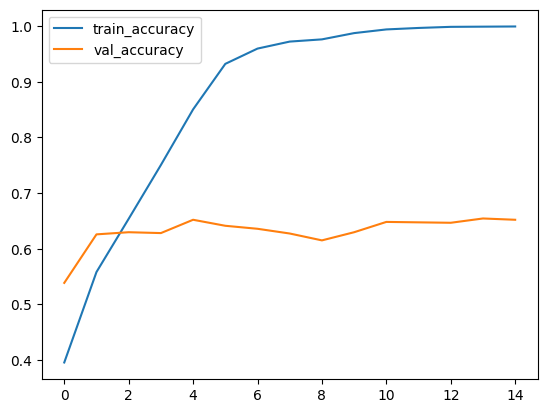

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Data Augementation

### 1. Let's define the Data Augmentation Pipeline

In [15]:
data_augmentation = models.Sequential([
    # Randomly flip the image horizontally (left-to-right)
    layers.RandomFlip("horizontal"), 
    
    # Randomly rotate the image by up to 20% of a full circle
    layers.RandomRotation(0.2),
    
    # Randomly zoom in on the image by up to 20% (0.2)
    layers.RandomZoom(0.2),
    
    # Randomly shift the image horizontally and vertically
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1) ])

### 2. Now let's integrate the Augmentation Pipeline into our main Model

* Now we will add data augmentation to our existing Keras model by inserting augmentation layers right before your first Conv2D layer. And will also use regularization technique like dropout.

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    # Input + Augmentation
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,  # augmentation pipeline

    # Convolutional Layers
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Flatten features
    layers.Flatten(),

    # Fully-connected dense layer with Regularization
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    # Output layer
    layers.Dense(5, activation='softmax')
])

### 3. Let's see how our model performs now

In [17]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy', 
    metrics = ['accuracy'])

history = model.fit(
    X_train_scaled, y_train,
    batch_size = 32,
    epochs=15,
    validation_data = (X_test_scaled, y_test))

Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - accuracy: 0.3125 - loss: 1.6489 - val_accuracy: 0.4514 - val_loss: 1.2732
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.4602 - loss: 1.2379 - val_accuracy: 0.5563 - val_loss: 1.1112
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5356 - loss: 1.1375 - val_accuracy: 0.5586 - val_loss: 1.1172
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5743 - loss: 1.0682 - val_accuracy: 0.5664 - val_loss: 1.0831
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5918 - loss: 1.0228 - val_accuracy: 0.6265 - val_loss: 0.9887
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6162 - loss: 0.9714 - val_accuracy: 0.6366 - val_loss: 0.9302
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6357 - loss: 0.9607 - val_accuracy: 0.6343 - val_loss: 0.9470
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6349 - loss: 0.9460 - val_accuracy: 0.6528 - 

### 4. Visualize Accuracy Curves

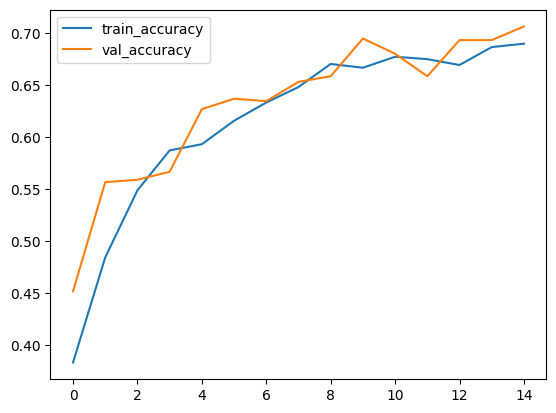

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Transfer Learning (MobileNetV2 Model)

### 1. Load and Freeze the Base Model

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top = False, # To exclude the top classification layer
    weights='imagenet' # To use pretrained weights
)

# Freeze the base model so its weights are not updated during the initial training
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2. Build the Full Transfer Learning Model

In [20]:
# Data Augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1)])

# Define input shape
inputs = layers.Input(shape=(224, 224, 3))

# Apply data augmentation to the inputs
x = data_augmentation(inputs)

# Pass augmented images to the frozen MobileNetV2 base
# Set training=False to keep BatchNorm layers frozen
x = base_model(x, training = False)

# Replace Convolutional feature maps with a GlobalAveragePooling2D layer
# This efficiently reduces the 3D feature map to a 1D feature vector
x = layers.GlobalAveragePooling2D()(x)

# Added our classification head (Our original Dense/Dropout layers)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Output layer: 5 flower classes
outputs = layers.Dense(5, activation='softmax')(x)

# Create the final Model object
model = models.Model(inputs, outputs)

# Display the summary (Note that only the final layers are Trainable)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])


In [22]:
history = model.fit(
    X_train_scaled, y_train,
    batch_size = 32,
    epochs=15,
    validation_data = (X_test_scaled, y_test))

Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.2315 - loss: 1.8896 - val_accuracy: 0.3171 - val_loss: 1.5685
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.2775 - loss: 1.7393 - val_accuracy: 0.4051 - val_loss: 1.4411
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.3393 - loss: 1.5779 - val_accuracy: 0.4684 - val_loss: 1.3370
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.3896 - loss: 1.4732 - val_accuracy: 0.5255 - val_loss: 1.2539
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.4201 - loss: 1.4274 - val_accuracy: 0.5741 - val_loss: 1.1795
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.4394 - loss: 1.3427 - val_accuracy: 0.6042 - val_loss: 1.1154
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.4963 - loss: 1.2730 - val_accuracy: 0.6373 - val_loss: 1.0588
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.5147 - loss: 1.2225 - val_accuracy: 0.6613 -

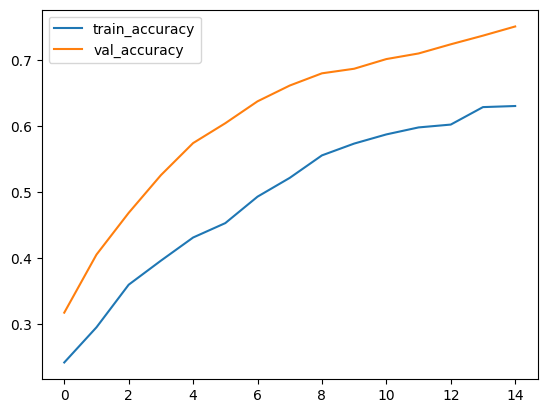

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Model Evaluation

In [26]:
y_pred = model.predict(X_test_scaled)
y_pred

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


array([[0.2229542 , 0.09669803, 0.05274376, 0.3092942 , 0.31830984],
       [0.07962508, 0.64511245, 0.20008814, 0.05317216, 0.02200214],
       [0.11284409, 0.17509958, 0.3870626 , 0.16243419, 0.16255963],
       ...,
       [0.11917392, 0.04814325, 0.08172793, 0.43344024, 0.3175147 ],
       [0.9123844 , 0.01500256, 0.00739615, 0.03697551, 0.02824139],
       [0.09010902, 0.69689715, 0.08701579, 0.07726394, 0.04871405]],
      dtype=float32)

In [29]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels

array([4, 1, 2, ..., 3, 0, 1])

### Classification Report

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test,y_pred_labels))
print(classification_report(y_test,y_pred_labels))

[[277  29  10  11   1]
 [ 22 204   7  13   3]
 [ 16  63 111  23   6]
 [  2   2  11 220  38]
 [  4   4   6  52 161]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       328
           1       0.68      0.82      0.74       249
           2       0.77      0.51      0.61       219
           3       0.69      0.81      0.74       273
           4       0.77      0.71      0.74       227

    accuracy                           0.75      1296
   macro avg       0.75      0.74      0.74      1296
weighted avg       0.76      0.75      0.75      1296



### Let's use flower names instead of labels

In [34]:
# This is the dictionary that we created in starting
flower_label_dict

{'dandelion': 0, 'daisy': 1, 'sunflower': 2, 'tulip': 3, 'rose': 4}

In [36]:
# Create reverse dictionary (label → class name)
label_to_class = {}
for flowers,labels in flower_label_dict.items():
    label_to_class[labels] = flowers

label_to_class

{0: 'dandelion', 1: 'daisy', 2: 'sunflower', 3: 'tulip', 4: 'rose'}

In [39]:
# To map y_true and y_pred to class names
y_test_class = [label_to_class[label] for label in y_test]
y_pred_class = [label_to_class[label] for label in y_pred_labels]

In [41]:
# Check the confusion_matrix and classification_report with classes
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test_class,y_pred_class))
print(classification_report(y_test_class,y_pred_class))

[[204  22   3   7  13]
 [ 29 277   1  10  11]
 [  4   4 161   6  52]
 [ 63  16   6 111  23]
 [  2   2  38  11 220]]
              precision    recall  f1-score   support

       daisy       0.68      0.82      0.74       249
   dandelion       0.86      0.84      0.85       328
        rose       0.77      0.71      0.74       227
   sunflower       0.77      0.51      0.61       219
       tulip       0.69      0.81      0.74       273

    accuracy                           0.75      1296
   macro avg       0.75      0.74      0.74      1296
weighted avg       0.76      0.75      0.75      1296



## Visualize the Confusion Matrix

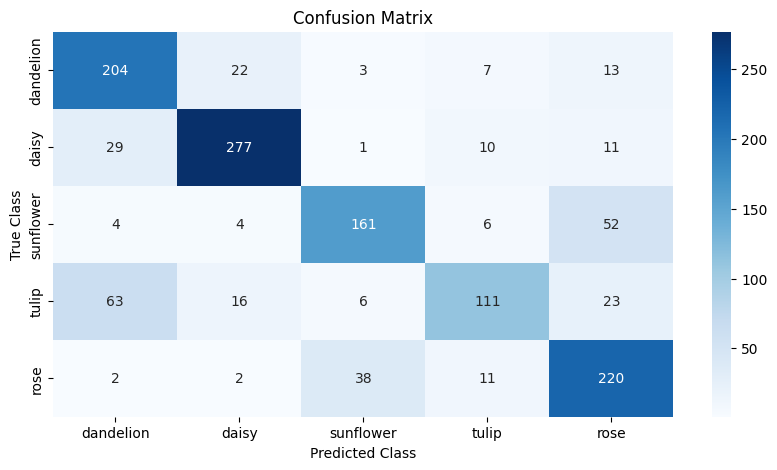

In [47]:
# To visualize the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, cmap='Blues', annot = True, fmt='d',
            xticklabels = flower_label_dict.keys(),
            yticklabels=flower_label_dict.keys())
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()